# Lab 2: 1D Filtering

## 1. OneD Kalman Filter For Filtering Yaw

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm, halfnorm
from math import sqrt

In [2]:
df_08_22_47 = pd.read_csv('data/2020-02-08_08_22_47.csv')
df_08_34_45 = pd.read_csv('data/2020-02-08_08_34_45.csv')
df_08_52_01 = pd.read_csv('data/2020-02-08_08_52_01.csv')

### 1a. Calculate Variance

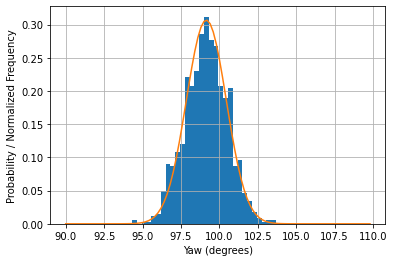

In [4]:
hist = df_08_22_47.hist(bins=30, column="Yaw(degrees)", density=True)
sigma = 1.3
mu = 99.15
x_axis = np.arange(90, 110, 0.2)

plt.ylabel("Probability / Normalized Frequency")
plt.xlabel("Yaw (degrees)")
# plt.title("Normalized Histogram and Probability Distribution for Yaw")

plt.title("")
plt.plot(x_axis, norm.pdf(x_axis,mu,sigma))
plt.show()

In [50]:
## variance = 1.69 
variance = (sigma)**2 

variance

1.6900000000000002

### 1b,c. Apply Kalman Correction Step & Plot
Done in separate file; thanks Andrew :)

## 2. Bayes Filter For Estimating Vehicle is stopped

In this part of the lab, we will make progress in answering the question: Parked or Not Parked?
This is an import capability for autonomous vehicles. Here we will only be asking the question:
Stopped or Not Stopped, although extra work could be done to modify the algorithm for the more
difficult question.

2a) Examine the Excel sheet that has [x,y,theta] data for ego vehicle and 6 other vehicles. 
At the same time, watch the video of the attached scene and try to spot each vehicle in the video.
The vehicles are described in a table in the Excel sheet, (i.e. far right columns).

2b) Plot speed histogram for car 4; Using this histogram, create a PDF that represents the conditional probability p(s|x = stopped).

In [21]:
nuscenes_data = pd.read_csv('data/E205_Lab2_NuScenesData.csv')
nuscenes_data.head()

,Time (s),X_ego,Y_ego,Yaw_ego,X_1,Y_1,Yaw_1,X_2,Y_2,Yaw_2,...,Yaw_3,X_4,Y_4,Yaw_4,X_5,Y_5,Yaw_5,X_6,Y_6,Yaw_6
0,0.0,599.849775,1647.641129,-0.500766,635.447,1620.546,-0.888442,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.5,603.568608,1645.536401,-0.518344,637.445,1618.566,-0.731363,660.000,1613.648,-1.976742,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,607.193716,1643.374074,-0.545476,639.933,1616.457,-0.696456,660.012,1613.639,-1.976742,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.5,610.730703,1641.142628,-0.574253,642.736,1614.065,-0.731363,660.025,1613.629,-1.976742,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,614.199961,1638.821691,-0.601656,646.361,1610.980,-0.713909,660.010,1613.556,-1.976742,...,NaN,NaN,NaN,NaN,662.526,1618.552,-2.096856,NaN,NaN,NaN


In [22]:
def get_speed(x_vector, y_vector, dt):
    """
        speed = distance / time
        We assume dt is constant, 
        and that len(x_vector) == len(y_vector).
    """
    x_list = x_vector.tolist()
    y_list = y_vector.tolist()
    speed_vector = []
    for t in range(len(x_list)-1):
        x_0 = x_list[t]
        y_0 = y_list[t]
        x_1 = x_list[t+1]
        y_1 = y_list[t+1]
        distance = sqrt((x_0 - x_1)**2 + (y_0 - y_1)**2)
        speed_vector.append(distance/dt)
    return pd.Series(speed_vector) 

In [23]:
def get_speed_with_time(car_df, dt):
    """
        speed = distance / time
        We assume dt is constant, 
        and that len(x_vector) == len(y_vector).
    """
    speed_vector = []
    time_vector = []
    for i in range(len(car_df)-1):
        _, x_0, y_0 = car_df.iloc[i]
        t, x_1, y_1 = car_df.iloc[i+1]
        distance = sqrt((x_0 - x_1)**2 + (y_0 - y_1)**2)
        speed_vector.append(distance/dt)
        time_vector.append(t)
    d = {'Time': time_vector, 'Speed': speed_vector}
    return pd.DataFrame(data=d)

car_data = nuscenes_data[["Time (s)","X_4", "Y_4"]].dropna()
speed_with_time = get_speed_with_time(car_data, 0.5)
speed_with_time.head()

,Time,Speed
0,6.5,0.066483
1,7.0,0.063655
2,7.5,0.000000
3,8.0,0.022627
4,8.5,0.021260


In [24]:
# other cars
car_data_ego = nuscenes_data[["Time (s)","X_ego", "Y_ego"]].dropna()
speed_with_time_ego = get_speed_with_time(car_data_ego, 0.5)
car_data_1 = nuscenes_data[["Time (s)","X_1", "Y_1"]].dropna()
speed_with_time_1 = get_speed_with_time(car_data_1, 0.5)
car_data_6 = nuscenes_data[["Time (s)","X_6", "Y_6"]].dropna()
speed_with_time_6 = get_speed_with_time(car_data_6, 0.5)

In [25]:
# stopped cars
car_4_x, car_4_y = nuscenes_data['X_4'][12:], nuscenes_data['Y_4'][12:]
speed_4 = get_speed(car_4_x, car_4_y, 0.5)

car_data_4 = nuscenes_data[["Time (s)","X_4", "Y_4"]].dropna()
speed_with_time_4 = get_speed_with_time(car_data_4, 0.5)

In [26]:
# moving cars
car_2_x, car_2_y = nuscenes_data['X_2'], nuscenes_data['Y_2']
speed_2 = get_speed(car_2_x, car_2_y, 0.5)
car_3_x, car_3_y = nuscenes_data['X_3'], nuscenes_data['Y_3']
speed_3 = get_speed(car_3_x, car_3_y, 0.5)
car_5_x, car_5_y = nuscenes_data['X_5'][4:], nuscenes_data['Y_5'][4:]
speed_5 = get_speed(car_5_x, car_5_y, 0.5)

car_data_2 = nuscenes_data[["Time (s)","X_2", "Y_2"]].dropna()
speed_with_time_2 = get_speed_with_time(car_data_2, 0.5)
car_data_3 = nuscenes_data[["Time (s)","X_3", "Y_3"]].dropna()
speed_with_time_3 = get_speed_with_time(car_data_3, 0.5)
car_data_5 = nuscenes_data[["Time (s)","X_5", "Y_5"]].dropna()
speed_with_time_5 = get_speed_with_time(car_data_5, 0.5)

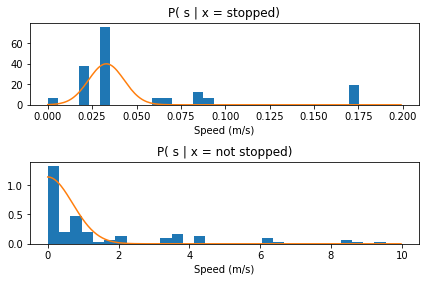

In [27]:
# plt.hist(speed_3, bins=50)
# plt.ylabel("Normalized Frequency")

mu_s = 0.033
mu_n = 0
sigma_s = 0.01 
sigma_n = 0.7

s = speed_2.append(speed_3).append(speed_5)
ax1 = plt.subplot(211)
ax1.hist(speed_4, bins=30,density=True)
ax1.set_title("P( s | x = stopped)")
ax1.set_xlabel("Speed (m/s)")
# ax1.set_ylabel("Normalized Frequency")

ax2 = plt.subplot(212)
ax2.hist(s,bins=30,density=True)
ax2.set_title("P( s | x = not stopped)")
ax2.set_xlabel("Speed (m/s)")
# ax2.set_ylabel("Normalized Frequency")

x_axis_s = np.arange(0,0.2,.001)
x_axis_n = np.arange(0,10,.02)
ax1.plot(x_axis_s, norm.pdf(x_axis_s,mu_s,sigma_s))
ax2.plot(x_axis_n, halfnorm.pdf(x_axis_n,mu_n,sigma_n))


plt.tight_layout(pad=1.0)
plt.show()

In [28]:
norm.pdf(0.025,mu_s,sigma_s)

28.96915527614827

In [31]:
prob_s_s = 0.6
prob_n_s = 0.4
prob_s_n = 0.25
prob_n_n = 0.75
    
def bayes_filter(speed_with_time):
    # initialize
    '''
    for t, _ in enumerate(speed_data):
        bel_x_t = speed_data[t]
        # predict
        bel_n = prediction_step(bel_x_t)
        bel_s = prediction_step(bel_x_t, stopped=False)
        # correct
        bel_x_t = [correction_step(bel_s), correction_step(bel_n, stopped=False)]
    '''
    bayes_filter = []
    x_t = speed_with_time.iloc[0]['Speed']
    bel_x_t = [norm.pdf(x_t,mu_s,sigma_s), halfnorm.pdf(x_t,mu_n,sigma_n)]
    for i in range(len(speed_with_time)):
        x_t = speed_with_time.iloc[i]['Speed']
        # predict
        bel_s = prediction_step(bel_x_t, stopped=True)
        bel_n = prediction_step(bel_x_t, stopped=False)
        # correct
        bel_x_t = [correction_step(bel_s, x_t, stopped=True), correction_step(bel_n, x_t, stopped=False)]
        bel_x_t = [x / (bel_x_t[0]+bel_x_t[1]) for x in bel_x_t]
        bayes_filter.append(bel_x_t) 
    bayes_filter = np.array(bayes_filter)
    return [bayes_filter.flatten('F')[:len(speed_with_time)], bayes_filter.flatten('F')[len(speed_with_time):]]
    
def prediction_step(prev, stopped = True):
    if stopped:
        bel_x_t = (prob_s_s)*prev[0] + (prob_s_n)*prev[1]
    else:
        bel_x_t = (prob_n_s)*prev[0] + (prob_n_n)*prev[1]
    return bel_x_t
    
def correction_step(prev, x_t, stopped = True):
    if stopped:
        bel_x_t = norm.pdf(x_t,mu_s,sigma_s)*prev
    else:
        bel_x_t = halfnorm.pdf(x_t,mu_n,sigma_n)*prev
    return bel_x_t


In [46]:
filter_ego = bayes_filter(speed_with_time_ego)
filter_1 = bayes_filter(speed_with_time_1)
filter_2 = bayes_filter(speed_with_time_2)
filter_3 = bayes_filter(speed_with_time_3)
filter_4 = bayes_filter(speed_with_time_4)
filter_5 = bayes_filter(speed_with_time_5)
filter_6 = bayes_filter(speed_with_time_6)

AttributeError: 'AxesSubplot' object has no attribute 'set_axis_bgcolor'

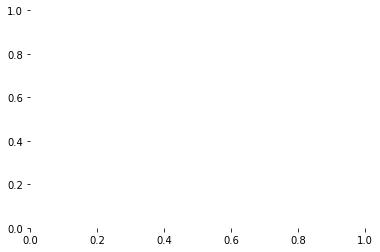

In [94]:
fig_size=(8,4)

ax1 = plt.subplot(321)
ax2 = plt.subplot(322)
ax3 = plt.subplot(323)
ax4 = plt.subplot(324)
ax5 = plt.subplot(325)
ax6 = plt.subplot(326)

ax1.plot(speed_with_time_1["Time"], filter_1[0])
ax2.plot(speed_with_time_2["Time"], filter_2[0])
ax3.plot(speed_with_time_3["Time"], filter_3[0])
ax4.plot(speed_with_time_4["Time"], filter_4[0])
ax5.plot(speed_with_time_5["Time"], filter_5[0])
ax6.plot(speed_with_time_6["Time"], filter_6[0])

big_ax = plt.subplot(111, frameon=False)
big_ax.set_axis_bgcolor('none')

plt.tight_layout(pad=0.5)

plt.show()


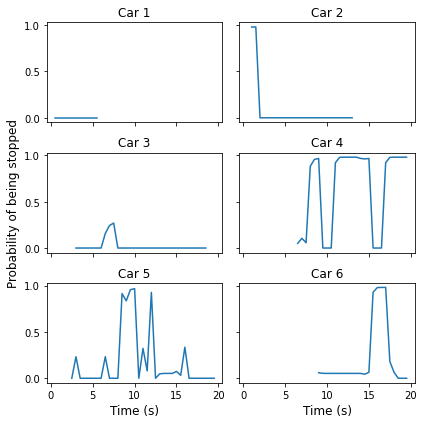

In [134]:
fig, axes2d = plt.subplots(nrows=3, ncols=2,
                           sharex=True, sharey=True,
                           figsize=(6,6))

# I am so sorry about this code ~daphne

for i, row in enumerate(axes2d):
    for j, cell in enumerate(row):
        car = 2*i + j
        cell.set_title(f"Car {car+1}")
        
        if car == 0:
            cell.plot(speed_with_time_1["Time"], filter_1[0])
        elif car == 1:
            cell.plot(speed_with_time_2["Time"], filter_2[0])
        elif car == 2:
            cell.set_ylabel("Probability of being stopped", fontsize=12)
            cell.plot(speed_with_time_3["Time"], filter_3[0])
        elif car == 3:
            cell.plot(speed_with_time_4["Time"], filter_4[0])
        elif car == 4:
            cell.plot(speed_with_time_5["Time"], filter_5[0])
        else:
            cell.plot(speed_with_time_6["Time"], filter_6[0])
        if i == len(axes2d) - 1:
            cell.set_xlabel("Time (s)", fontsize=12)
            
plt.tight_layout()

In [ ]:
bel_x_t = [1,2]
bel_x_t = [x / (bel_x_t[0]+bel_x_t[1]) for x in bel_x_t]
bel_x_t

In [ ]:
filter_6

## 3. Applying Bayes Filter to Police Violence Data

prob_white = 73.0
prob_black = 12.7
prob_asian = 5.4
prob_hispanic = 17.6


In [124]:
prob_white = 73.0
prob_black = 12.7
prob_asian = 5.4
prob_hispanic = 17.6

prob_sum = prob_white + prob_black + prob_asian + prob_hispanic


# normalizeeee
prob_white = 73.0/prob_sum
prob_black = 12.7/prob_sum
prob_asian = 5.4/prob_sum
prob_hispanic = 17.6/prob_sum

print(prob_white, prob_black, prob_asian, prob_hispanic)


0.6715731370745169 0.1168353265869365 0.04967801287948482 0.16191352345906163


In [125]:
pk = pd.read_csv("data/police_killings.csv")
pk_armed = pk[["Unarmed","Victim's race"]].dropna()
races = ['White', 'Black', 'Hispanic', 'Asian']
pk_armed = pk_armed[pk_armed["Victim's race"].isin(races)]
pk_armed["Unarmed"].replace({'Allegedly Armed':'Armed'}, inplace = True)
arm_options = ['Unarmed', 'Armed', 'Unclear']
pk_armed = pk_armed[pk_armed["Unarmed"].isin(arm_options)]


In [126]:
pk_n = pk_armed[pk_armed['Unarmed']=='Unarmed']
pk_a = pk_armed[pk_armed['Unarmed']=='Armed']
pk_u = pk_armed[pk_armed['Unarmed']=='Unclear']

p_w_n = pk_n["Victim's race"].value_counts()['White']/len(pk_n)
p_w_a = pk_a["Victim's race"].value_counts()['White']/len(pk_a)
p_w_u = pk_u["Victim's race"].value_counts()['White']/len(pk_u)

p_b_n = pk_n["Victim's race"].value_counts()['Black']/len(pk_n)
p_b_a = pk_a["Victim's race"].value_counts()['Black']/len(pk_a)
p_b_u = pk_u["Victim's race"].value_counts()['Black']/len(pk_u)

p_h_n = pk_n["Victim's race"].value_counts()['Hispanic']/len(pk_n)
p_h_a = pk_a["Victim's race"].value_counts()['Hispanic']/len(pk_a)
p_h_u = pk_u["Victim's race"].value_counts()['Hispanic']/len(pk_u)

p_a_n = pk_n["Victim's race"].value_counts()['Asian']/len(pk_n)
p_a_a = pk_a["Victim's race"].value_counts()['Asian']/len(pk_a)
p_a_u = pk_u["Victim's race"].value_counts()['Asian']/len(pk_u)

In [127]:
print("p_w_n", p_w_n)
print("p_w_a", p_w_a)
print("p_w_u", p_w_u)
print("p_b_n", p_b_n)
print("p_b_a", p_b_a)
print("p_b_u", p_b_u)
print("p_h_n", p_h_n)
print("p_h_a", p_h_a)
print("p_h_u", p_h_u)
print("p_a_n", p_a_n)
print("p_a_a", p_a_a)
print("p_a_u", p_a_u)

p_w_n 0.4515484515484515
p_w_a 0.5168798490249529
p_w_u 0.45940959409594095
p_b_n 0.3356643356643357
p_b_a 0.2738519605787377
p_b_u 0.28044280442804426
p_h_n 0.2007992007992008
p_h_a 0.18976724680226462
p_h_u 0.24354243542435425
p_a_n 0.011988011988011988
p_a_a 0.019500943594044872
p_a_u 0.016605166051660517


In [128]:
pk_age = pk[["Victim's age","Victim's race"]].dropna()

pk_age = pk_age[pk_age['Victim\'s age'].notnull()]
pk_age = pk_age[pk_age["Victim\'s age"] != 'Unknown']
pk_age = pk_age[pk_age["Victim\'s age"] != '40s']
pk_age["Victim's age"] = pd.to_numeric(pk_age["Victim\'s age"], errors='coerce')
pk_age["Victim's age"][pk_age["Victim's age"] < 20] = 0
print(pk_age["Victim\'s age"].value_counts())
pk_age["Victim's age"][pk_age["Victim's age"] >= 20] = 1
print(pk_age["Victim\'s age"].value_counts())

0      409
25     254
27     244
34     243
32     240
      ... 
95       1
93       1
79       1
91       1
107      1
Name: Victim's age, Length: 73, dtype: int64
1    7048
0     409
Name: Victim's age, dtype: int64


<ipython-input-128-d4268e835403>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pk_age["Victim's age"][pk_age["Victim's age"] < 20] = 0
<ipython-input-128-d4268e835403>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pk_age["Victim's age"][pk_age["Victim's age"] >= 20] = 1


In [129]:
pk_w = pk_age[pk_age["Victim's race"]=='White']
pk_b = pk_age[pk_age["Victim's race"]=='Black']
pk_h = pk_age[pk_age["Victim's race"]=='Hispanic']
pk_a = pk_age[pk_age["Victim's race"]=='Asian']

p_w_y = pk_w["Victim's age"].value_counts()[0]/len(pk_w)
p_b_y = pk_b["Victim's age"].value_counts()[0]/len(pk_b)
p_h_y = pk_h["Victim's age"].value_counts()[0]/len(pk_h)
p_a_y = pk_a["Victim's age"].value_counts()[0]/len(pk_a)

In [130]:
pk_w["Victim's age"].value_counts()

1    3250
0     105
Name: Victim's age, dtype: int64

In [131]:
print("p_w_y", p_w_y)
print("p_b_y", p_b_y)
print("p_h_y", p_h_y)
print("p_a_y", p_a_y)

p_w_y 0.03129657228017884
p_b_y 0.08883116883116883
p_h_y 0.07401696222050887
p_a_y 0.05084745762711865


In [132]:
# part c.a

p_w_case_a = p_w_a*.8+p_w_u*.2
p_b_case_a = p_b_a*.8+p_w_u*.2
p_h_case_a = p_h_a*.8+p_w_u*.2
p_a_case_a = p_a_a*.8+p_w_u*.2

print(p_w_case_a, p_b_case_a, p_h_case_a, p_a_case_a)

#c.b

p_w_case_b = p_w_n*.8+p_w_u*.2
p_b_case_b = p_b_n*.8+p_w_u*.2
p_h_case_b = p_h_n*.8+p_w_u*.2
p_a_case_b = p_a_n*.8+p_w_u*.2

print(p_w_case_b, p_b_case_b, p_h_case_b, p_a_case_b)

0.5053857980391505 0.3109634872821784 0.2436957162609999 0.1074826736944241
0.4531206800579495 0.36041338735065676 0.25252127945854885 0.10147232840959779


In [133]:
p_w_twnty = p_w_y*prob_white
p_b_twnty = p_b_y*prob_black
p_a_twnty = p_a_y*prob_asian
p_h_twnty = p_h_y*prob_hispanic

sum_twnty = p_w_twnty + p_b_twnty + p_a_twnty + p_h_twnty
p_w_twnty = p_w_twnty / sum_twnty
p_b_twnty = p_b_twnty / sum_twnty
p_a_twnty = p_a_twnty / sum_twnty
p_h_twnty = p_h_twnty / sum_twnty

print(p_w_twnty,p_b_twnty,p_a_twnty,p_h_twnty)

0.457838267324923 0.22607969163776587 0.05502441798484613 0.2610576230524651
